## Predicting gene lenght - multiple regression model

I aim to predict gene lenght base on the bases composition and chromosome at which the gene is localised. Previous charts do not show a particular pattern, therefor I do not expect a wonderful performance. But let's try anyway.

In [17]:
# importing desired libraries and functions

import pandas as pd
import matplotlib.pyplot as plt
import random

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer, mean_squared_error, median_absolute_error, r2_score

In [21]:
random.seed(10)

In [2]:
# importing data
all_genes_df = pd.read_csv('all_genes_df.csv')
all_genes_df.head()

,Unnamed: 0,gene_ID,chromosome,gene_length[bp],A_content[%],T_content[%],C_content[%],G_content[%],GC_content[%],category
0,0,YAL001C,I,3573,35.32046,27.59586,15.81304,21.27064,37.08368,GC content below \n length above
1,1,YAL002W,I,3825,31.89542,30.92810,18.74510,18.43137,37.17647,GC content below \n length above
2,2,YAL003W,I,987,29.68592,31.10436,18.84498,20.36474,39.20972,GC content below \n length below
3,3,YAL005C,I,1929,29.13427,26.80145,21.15086,22.91343,44.06429,GC content above \n length above
4,4,YAL007C,I,648,30.86420,32.09877,17.59259,19.44444,37.03703,GC content below \n length below


Before creating regression model, it's good to convert non-numeric (chromosome, category),  type of data into numeric type of data. For that, I will use map() function.

In [3]:
chromosome_mapper = {}
for index, value in enumerate(all_genes_df['chromosome'].unique()):
    chromosome_mapper[value] = index + 1
all_genes_df['chromosome'] = all_genes_df['chromosome'].map(chromosome_mapper)

In [4]:
all_genes_df.head()

,Unnamed: 0,gene_ID,chromosome,gene_length[bp],A_content[%],T_content[%],C_content[%],G_content[%],GC_content[%],category
0,0,YAL001C,1,3573,35.32046,27.59586,15.81304,21.27064,37.08368,GC content below \n length above
1,1,YAL002W,1,3825,31.89542,30.92810,18.74510,18.43137,37.17647,GC content below \n length above
2,2,YAL003W,1,987,29.68592,31.10436,18.84498,20.36474,39.20972,GC content below \n length below
3,3,YAL005C,1,1929,29.13427,26.80145,21.15086,22.91343,44.06429,GC content above \n length above
4,4,YAL007C,1,648,30.86420,32.09877,17.59259,19.44444,37.03703,GC content below \n length below


Done. Let's start building the model. Gene length is going to be predicted based on chromosome localisation and content of each of the bases - this parameters are pontentially more informative than GC content only.

In [5]:
# preparing y and X datasets
y = all_genes_df['gene_length[bp]']
X = all_genes_df.drop(['gene_length[bp]', 'gene_ID', 'category', 'GC_content[%]'], axis=1)

Model building road map:

- polynomial regression model predicting gene lenght based on chromosome localisation and A, T, G and C contents. Contents of each bases are in theory more informative than GC content only

- nested cross-validation as a general good practice in model building. Inner loop done by GridSearchCV() function select an unbiased optimal parameter (in our case a degree of polynomial) for the model. Outer loop done by cross_validate() function results in more accurate model evaluation - testing model on several test sets prevents us from overestimating (or underestimating) model performance. To make sure that testing sets are not participating in model training, GridSearchCV() is used as an estimaor argument in cross_validate().

- R2 score will be used in GridSearchCV() for selecting optimal degree for the model.

- I want to know what is the best degree selected by GridSearchCV() during each split done by cross_validate() to see if there is a 'universal' optimal degree for various training sets. For that, I extract the optimal degree for each split by using .best_params_. Results will be stored in best_degrees list.

- several metrics will be used: ean of R2 scores, root mean square errors and  median absolute errors and their standard deviations. This will give us more information about model performance.

In [25]:
# defying an estimator and list of degrees for checking

poly = PolynomialFeatures()
lin_reg = LinearRegression()
estimator = make_pipeline(poly, lin_reg)

# selecting parameters for model tuning
param = {'polynomialfeatures__degree' : [1,2,3,4]}

# creating best_degrees list for storing best degrees in each cross_validate split.
best_degrees = []

# preparing metrics for model evaluation
scoring = {'r2' : make_scorer(r2_score), \
           'mse' : make_scorer(mean_squared_error), \
           'mae' : make_scorer(median_absolute_error)}

# performing nested cross-validation. R2 score for model tuning and metrics in scoring for model evaluation

cv_inner = 10
cv_outer = 10

best_model = GridSearchCV(estimator, param, cv=cv_inner, scoring='r2')
scores = cross_validate(best_model, X, y, cv=cv_outer, scoring=scoring, return_estimator=True)

# calculating means and standard deviations of each metric scores from splits done by cross_validate()
r2_mean = round((scores['test_r2']).mean(), 2)
r2_std = round((scores['test_r2']).std(), 2)

rmse_mean = round((scores['test_mse']**0.5).mean(), 2) # extracting roots from mean_squared_errors
rmse_std = round((scores['test_mse']**0.5).std(), 2)

mae_mean = round((scores['test_mae']).mean(), 2)
mae_std = round((scores['test_mae']).std(), 2)

# extracting best_params for each cross_validate() (outer loop) split
for i in range(cv_outer):
    best_degrees.append(scores['estimator'][i].best_params_['polynomialfeatures__degree'])


# results of the model evaluation
print('Mean R2 score =', r2_mean, "+/-", r2_std)
print('Mean root mean square error =', rmse_mean, "+/-", rmse_std)
print('Mean median absolute error =', mae_mean, "+/-", mae_std)
print('Selected optimal degrees:', best_degrees)

Mean R2 score = 0.1 +/- 0.02
Mean root mean square error = 1081.36 +/- 82.08
Mean median absolute error = 578.45 +/- 21.86
Selected optimal degrees: [2, 2, 2, 3, 3, 3, 3, 3, 2, 3]


Well, as predicted in data exploration part, my regression model predicting gene length is useless. Standard deviations for each metrics are rather low, which shows that model performs comparably in various tests sets. In each split in outer loop 3 is selected as the most optimal degree for model functioning. 

Despite model evaluation is not encouraging, it is still interesting, however, that the R2 score, despite being very low, is above 0. One would expect that gene length, chromosome localization and bases contents are independent features, but here I show that there is a weak relationship between them. Another interesting thing is that median absolute error is much lover than root mean square error. This means that for some genes model performs much better, having a mistake below 568 bases for 50% of the genes, while for the whole dataset the average error is 1070 bases.

The GridSearchCV() function, in each cross_validate() split, always selected 3 as an optimal degree. I still want to see how model performs for other degrees. For that, I create model_performance function, which will plot model evaluation metrics (R2 score, root mean square error, median absolute error) for each degree. to_degree argument defines till what polynomial degree (starting from 1) the function will prepare model evaluation. Function body is based on the code written in the previous cell, however only a single cross-validation will be performed since we want metrics for each degree. This single cross-validation will yield more accurate model evaluation, because model is tested on several testing sets. The set is splited the same way during each cross-validation, every degree will be tested on the same datasets

In [26]:
def model_performance(to_degree, X, y):
    
    degrees = list(range(1, to_degree+1))
    
    # preparing lists for storing metric score means and standard deviations
    r2_means = []
    rmse_means = []
    mae_means = []
    
    r2_std = []
    rmse_std = []
    mae_std = []
    
    
    # loop collecting metric scores for each degree
    for deg in degrees:
        poly = PolynomialFeatures(deg)
        lin_reg = LinearRegression()
        estimator = make_pipeline(poly, lin_reg)
        
        # preparing metrics
        scoring = {'r2' : make_scorer(r2_score), \
                   'mse' : make_scorer(mean_squared_error), \
                   'mae' : make_scorer(median_absolute_error)}
        
        # cross-validation    
        scores = cross_validate(estimator, X, y, cv=10, scoring=scoring)
           
        # appending lists of means and stds
        r2_means.append((scores['test_r2']).mean())
        rmse_means.append((scores['test_mse']**0.5).mean()) # root of mse
        mae_means.append((scores['test_mae']).mean()) # converting for absolute values
    
        r2_std.append((scores['test_r2']).std())
        rmse_std.append((scores['test_mse']**0.5).std()) # root of mse
        mae_std.append((scores['test_mae']).std()) # converting for absolute values
        
    
    # plotting models evaluations
    fig, (ax1, ax2, ax3) = plt.subplots(3)
    fig.set_size_inches([5, 9])
                       
    ax1.errorbar(degrees, r2_means, yerr=r2_std, capsize=5, marker='o', linestyle='none')
    ax1.set_title('R2 score')
    ax1.set_xticks(degrees)
    
    ax2.errorbar(degrees, rmse_means, yerr=rmse_std, capsize=5, marker='o', linestyle='none')
    ax2.set_title('Root mean squared error')
    ax2.set_xticks(degrees)
    
    ax3.errorbar(degrees, mae_means, yerr=mae_std, capsize=5, marker='o', linestyle='none')
    ax3.set_title('Median absolute error')
    ax3.set_xticks(degrees)
    
    plt.tight_layout()
    plt.show()        

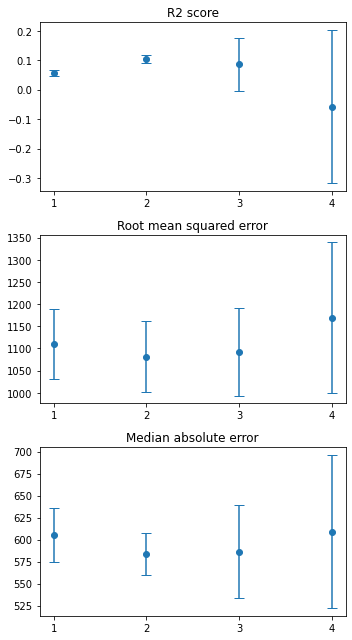

In [27]:
model_performance(4, X, y)

The chart shows that 3 seems to be optimal degree - not only R2 score is the highers, the erros for other metrics are the lowest.

Of course, I played a bit with higher degrees, however above the 4th model become very unstable (huge standard deviations) and difference between 1sth and 4th degrees are not visible on the chart, so I leave charts up to the 4th degree only